# Titanic Survivor Classifier

This notebook implements logistic regression with Tensorflow to predict survivors of the 
Titanic disaster. 

The data comes from kaggle.com and has been pre-split into testing and training datasets

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from scipy.stats           import mode

In [2]:
# Load training and testing datasets
train_df = pd.read_csv('data/train.csv')
test_df  = pd.read_csv('data/test.csv')
test_labels = pd.read_csv('data/gender_submission.csv')

In [3]:
# Drop unnecessary columns like name and ticket number since
# These should not have an effect on our model
train_df = train_df.drop(['Name','Ticket'],axis=1)
test_df  = test_df.drop(['Name','Ticket'],axis=1)

# Make dataframes of features and labels from the original dataframes
train_feats  = train_df.drop(['Survived'],axis=1)
train_labels = train_df['Survived']

test_feats = test_df
test_labels = test_labels.drop(['PassengerId'],axis=1)

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,71.2833,C85,C
2,3,1,3,female,26.0,0,0,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,53.1000,C123,S
4,5,0,3,male,35.0,0,0,8.0500,NaN,S


## Explore the Data

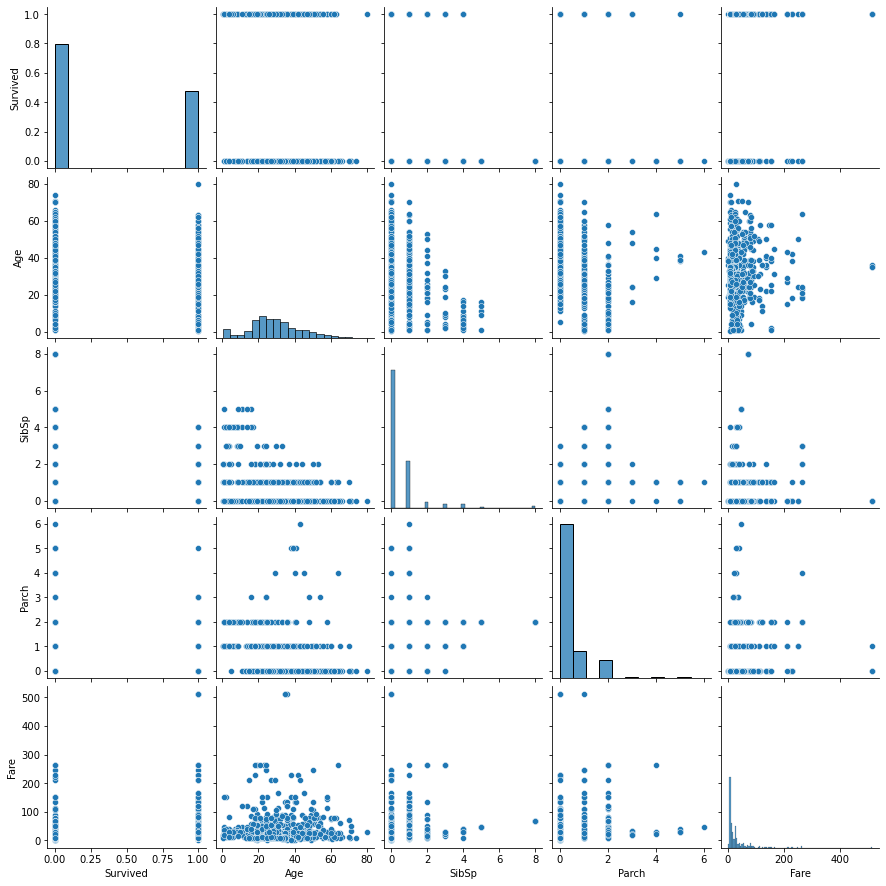

In [5]:
# Make pair plot of numerical variables
sns.pairplot(train_df[['Survived','Age','SibSp','Parch','Fare']],diag_kind='hist')

It does not seem like many of the numerical variables have significant correlations with 
survival rate. We can check the correlations using a correlation plot using seaborn's heatmap and
pandas corr() function. 

NOTE: It seems like the 'Fare' variable is heavily right skewed. This can cause problems in our model
so we will address this later in the data processing section.

<AxesSubplot:>

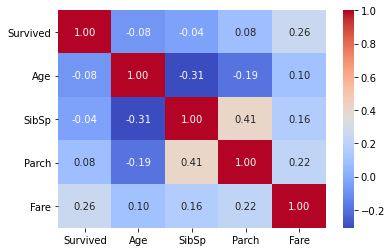

In [6]:
# Check correlations of numerical variables to survival probability
sns.heatmap(train_df[['Survived','Age','SibSp','Parch','Fare']].corr(),cmap='coolwarm',annot=True,fmt='.2f')


The Fare variable seems to be the most correlated with the survival rate although the correlation is
pretty weak

Text(0.5, 0, 'Sex')

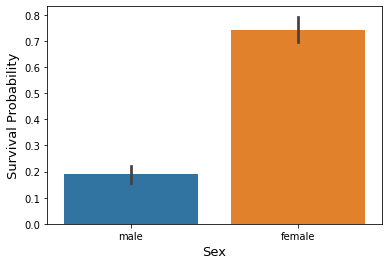

In [7]:
# Check survival probability by sex
sns.barplot(x = 'Sex', y ='Survived', data = train_df)
plt.ylabel('Survival Probability',fontsize=13)
plt.xlabel('Sex',fontsize=13)

Text(0.5, 0, 'P Class')

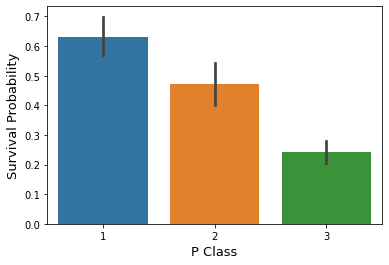

In [8]:
# Survival rate for each class
sns.barplot(x = 'Pclass', y ='Survived', data = train_df)
plt.ylabel('Survival Probability',fontsize=13)
plt.xlabel('P Class',fontsize=13)

Text(0.5, 0, 'Embarked From')

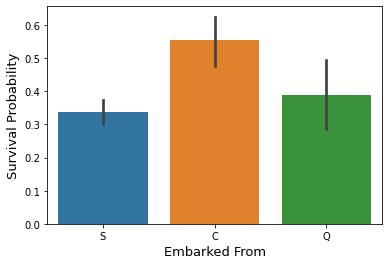

In [9]:
# Survival rate based on location 
sns.barplot(x = 'Embarked', y ='Survived', data = train_df)
plt.ylabel('Survival Probability',fontsize=13)
plt.xlabel('Embarked From',fontsize=13)

It seems that people who embark from 'C' tend to have a higher survival rate. This could be because
that particular location had more first class passengers. As we saw above, first class passengers have a 
higher survival rate so this may be the cause of the higher survival rate of those who embark from 'C'

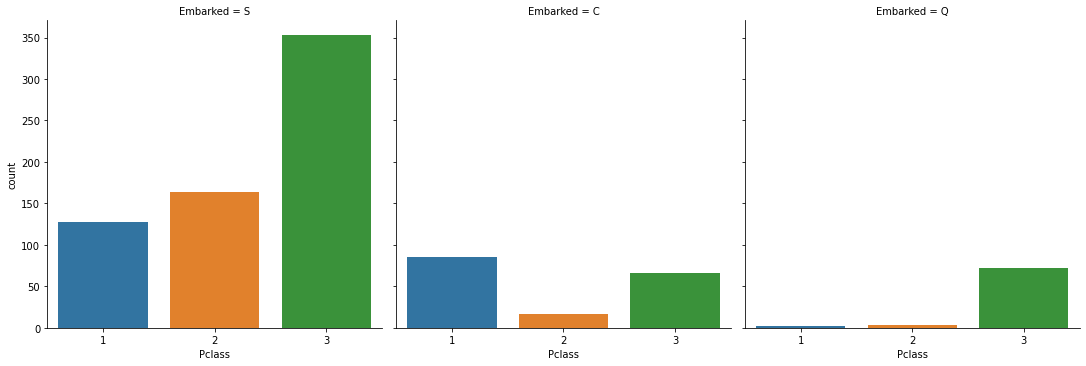

In [10]:
# check class of people from each embarkation point
sns.catplot(x='Pclass',col='Embarked',data=train_df,kind='count')

The plots above show that the reason for the survival bias by embarkation point is due to the higher number
of third class passengers who embarked from 'S' who then have a lower survival rate.

## Process Data

Now we will process our data into a form that the tensorflow model will understand. We
will encode our categorical values into integers such as male=0 and female=1. We also want
to deal with missing data.

In [11]:
train_df.isnull().sum().sort_values(ascending = False)

Cabin          687
Age            177
Embarked         2
Fare             0
Parch            0
SibSp            0
Sex              0
Pclass           0
Survived         0
PassengerId      0
dtype: int64

In [12]:
# Since cabin has almost 700 missing values we will drop this column from our train and test data
train_feats = train_feats.drop(['Cabin'],axis=1)
test_feats  = test_feats.drop(['Cabin'],axis=1)

In [13]:
# Fill missing age values with the median age of all passengers
all_ages = np.concatenate((train_feats['Age'].dropna().values,test_feats['Age'].dropna().values))
med_ages = np.median(all_ages)
train_feats['Age'].fillna(med_ages,inplace=True)
test_feats['Age'].fillna(med_ages,inplace=True)

# Fill missing embarkation points with the most common embarkation point
mode = train_feats['Embarked'].dropna().mode()[0]
train_feats.fillna(mode,inplace=True)

In [14]:
# Now check missing values for the testing set
test_feats.isnull().sum().sort_values(ascending = False)

Fare           1
Embarked       0
Parch          0
SibSp          0
Age            0
Sex            0
Pclass         0
PassengerId    0
dtype: int64

In [15]:
# Calculate the median fare and replace missing fare value
all_fares = np.concatenate((train_feats['Fare'].dropna().values,test_feats['Fare'].dropna().values))
med_fare = np.median(all_fares)
test_feats['Fare'].fillna(med_fare,inplace=True)

In [16]:
# Encode 'Sex' variable as integers
train_feats['Sex'] = train_feats['Sex'].map({'male':0,'female':1})
test_feats['Sex'] = test_feats['Sex'].map({'male':0,'female':1})

# Encode 'Embarked' variable as integers
train_feats['Embarked'] = train_feats['Embarked'].map({'S':1,'C':2,'Q':3})
test_feats['Embarked'] = test_feats['Embarked'].map({'S':1,'C':2,'Q':3})

In [19]:
# Transform the 'Fare' variable with a log transformation to fix the heavy right skew
train_feats['Fare'] = train_feats['Fare'].apply(lambda x: np.log(x) if x>0 else 0)
test_feats['Fare']  = test_feats['Fare'].apply(lambda x: np.log(x) if x>0 else 0)

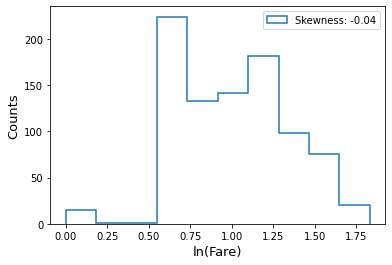

In [20]:
# Check what the Fare looks like after the transformation
plt.hist(train_feats['Fare'],histtype='step',lw=1.5,
         label='Skewness: %.2f' % train_feats['Fare'].skew())
plt.xlabel('ln(Fare)',fontsize=13)
plt.ylabel('Counts',fontsize=13)
plt.legend()
plt.show()

Compare this to the original 'Fare' distribution which was much more skewed:

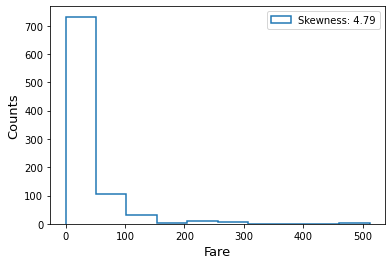

In [21]:
# Original fare distribution
plt.hist(train_df['Fare'],histtype='step',lw=1.5,
         label='Skewness: %.2f' % train_df['Fare'].skew())
plt.xlabel('Fare',fontsize=13)
plt.ylabel('Counts',fontsize=13)
plt.legend()
plt.show()

## Build the Model

We will use tf.keras to build a neural network to perform logistic regression. Before feeding in our
data to the model we will need to fit and transform the data using the MinMaxScaler

In [34]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.01),metrics='binary_accuracy')

In [35]:
x_train = train_feats.to_numpy()
y_train = train_labels.to_numpy().reshape(-1,1)

In [36]:
model.fit(x_train,y_train,epochs=1000)

Epoch 1/1000
28/28 [==============================] - 0s 1ms/step - loss: 48.7007 - binary_accuracy: 0.6184
Epoch 2/1000
28/28 [==============================] - 0s 1ms/step - loss: 7.7181 - binary_accuracy: 0.5051
Epoch 3/1000
28/28 [==============================] - 0s 1ms/step - loss: 1.5602 - binary_accuracy: 0.5185
Epoch 4/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.7367 - binary_accuracy: 0.6420
Epoch 5/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.6302 - binary_accuracy: 0.6779
Epoch 6/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.5491 - binary_accuracy: 0.7183
Epoch 7/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.5281 - binary_accuracy: 0.7419
Epoch 8/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.5030 - binary_accuracy: 0.7609
Epoch 9/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.5282 - binary_accuracy: 0.7520
Epoch 10/1000
28/28 [===============

28/28 [==============================] - 0s 1ms/step - loss: 0.4758 - binary_accuracy: 0.7901
Epoch 77/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.4612 - binary_accuracy: 0.7890
Epoch 78/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.4782 - binary_accuracy: 0.7946
Epoch 79/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4765 - binary_accuracy: 0.7845
Epoch 80/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4513 - binary_accuracy: 0.8081
Epoch 81/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4716 - binary_accuracy: 0.7901
Epoch 82/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4808 - binary_accuracy: 0.7912
Epoch 83/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4669 - binary_accuracy: 0.7879
Epoch 84/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.4686 - binary_accuracy: 0.7946
Epoch 85/1000
28/28 [=====================

28/28 [==============================] - 0s 1ms/step - loss: 0.4738 - binary_accuracy: 0.7946
Epoch 152/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.5214 - binary_accuracy: 0.7710
Epoch 153/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4837 - binary_accuracy: 0.7957
Epoch 154/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4685 - binary_accuracy: 0.7912
Epoch 155/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.4861 - binary_accuracy: 0.7924
Epoch 156/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.4625 - binary_accuracy: 0.7912
Epoch 157/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.5416 - binary_accuracy: 0.7632
Epoch 158/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.5872 - binary_accuracy: 0.7520
Epoch 159/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.5086 - binary_accuracy: 0.7755
Epoch 160/1000
28/28 [============

28/28 [==============================] - 0s 2ms/step - loss: 0.4764 - binary_accuracy: 0.7969
Epoch 227/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.4774 - binary_accuracy: 0.7912
Epoch 228/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.4827 - binary_accuracy: 0.8002
Epoch 229/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4780 - binary_accuracy: 0.7868
Epoch 230/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.4565 - binary_accuracy: 0.8025
Epoch 231/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4860 - binary_accuracy: 0.8058
Epoch 232/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.5302 - binary_accuracy: 0.7677
Epoch 233/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.6350 - binary_accuracy: 0.7351
Epoch 234/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4730 - binary_accuracy: 0.7912
Epoch 235/1000
28/28 [============

28/28 [==============================] - 0s 2ms/step - loss: 0.5006 - binary_accuracy: 0.7778
Epoch 302/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.4834 - binary_accuracy: 0.7879
Epoch 303/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.4488 - binary_accuracy: 0.7980
Epoch 304/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4480 - binary_accuracy: 0.8025
Epoch 305/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.5067 - binary_accuracy: 0.7823
Epoch 306/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4997 - binary_accuracy: 0.7722
Epoch 307/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.4722 - binary_accuracy: 0.7868
Epoch 308/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.5027 - binary_accuracy: 0.7677
Epoch 309/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4904 - binary_accuracy: 0.7868
Epoch 310/1000
28/28 [============

28/28 [==============================] - 0s 2ms/step - loss: 0.4573 - binary_accuracy: 0.8058
Epoch 377/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.5518 - binary_accuracy: 0.7744
Epoch 378/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.4839 - binary_accuracy: 0.7733
Epoch 379/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.5259 - binary_accuracy: 0.7868
Epoch 380/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.5304 - binary_accuracy: 0.7744
Epoch 381/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.4930 - binary_accuracy: 0.7912
Epoch 382/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.5111 - binary_accuracy: 0.7755
Epoch 383/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.5720 - binary_accuracy: 0.7587
Epoch 384/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.5478 - binary_accuracy: 0.7643
Epoch 385/1000
28/28 [============

28/28 [==============================] - 0s 1ms/step - loss: 0.4807 - binary_accuracy: 0.7935
Epoch 452/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.4988 - binary_accuracy: 0.7901
Epoch 453/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.4909 - binary_accuracy: 0.7856
Epoch 454/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4773 - binary_accuracy: 0.7924
Epoch 455/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.5528 - binary_accuracy: 0.7609
Epoch 456/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4815 - binary_accuracy: 0.7856
Epoch 457/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4601 - binary_accuracy: 0.7946
Epoch 458/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.5236 - binary_accuracy: 0.7811
Epoch 459/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.4634 - binary_accuracy: 0.7901
Epoch 460/1000
28/28 [============

28/28 [==============================] - 0s 1ms/step - loss: 0.4635 - binary_accuracy: 0.8002
Epoch 526/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4546 - binary_accuracy: 0.7969
Epoch 527/1000
28/28 [==============================] - 0s 978us/step - loss: 0.4821 - binary_accuracy: 0.7856
Epoch 528/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4973 - binary_accuracy: 0.7800
Epoch 529/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.5327 - binary_accuracy: 0.7643
Epoch 530/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.5158 - binary_accuracy: 0.7688
Epoch 531/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.5157 - binary_accuracy: 0.7643
Epoch 532/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.5049 - binary_accuracy: 0.7879
Epoch 533/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4816 - binary_accuracy: 0.7733
Epoch 534/1000
28/28 [==========

28/28 [==============================] - 0s 2ms/step - loss: 0.4927 - binary_accuracy: 0.7778
Epoch 601/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.5394 - binary_accuracy: 0.7710
Epoch 602/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4895 - binary_accuracy: 0.7755
Epoch 603/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4838 - binary_accuracy: 0.7924
Epoch 604/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.4754 - binary_accuracy: 0.7834
Epoch 605/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4805 - binary_accuracy: 0.8058
Epoch 606/1000
28/28 [==============================] - 0s 4ms/step - loss: 0.4665 - binary_accuracy: 0.8013
Epoch 607/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.5224 - binary_accuracy: 0.7677
Epoch 608/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.5232 - binary_accuracy: 0.7722
Epoch 609/1000
28/28 [============

28/28 [==============================] - 0s 1ms/step - loss: 0.4610 - binary_accuracy: 0.7924
Epoch 676/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4847 - binary_accuracy: 0.7957
Epoch 677/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4849 - binary_accuracy: 0.7924
Epoch 678/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4850 - binary_accuracy: 0.7946
Epoch 679/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4729 - binary_accuracy: 0.7957
Epoch 680/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.4746 - binary_accuracy: 0.7957
Epoch 681/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4659 - binary_accuracy: 0.7935
Epoch 682/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.5216 - binary_accuracy: 0.7800
Epoch 683/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.5009 - binary_accuracy: 0.7868
Epoch 684/1000
28/28 [============

28/28 [==============================] - 0s 1ms/step - loss: 0.4648 - binary_accuracy: 0.7901
Epoch 751/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.5268 - binary_accuracy: 0.7778
Epoch 752/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.5087 - binary_accuracy: 0.7744
Epoch 753/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.5578 - binary_accuracy: 0.7643
Epoch 754/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.5856 - binary_accuracy: 0.7553
Epoch 755/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.5025 - binary_accuracy: 0.7767
Epoch 756/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4790 - binary_accuracy: 0.7935
Epoch 757/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.4521 - binary_accuracy: 0.8002
Epoch 758/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4662 - binary_accuracy: 0.8036
Epoch 759/1000
28/28 [============

28/28 [==============================] - 0s 2ms/step - loss: 0.5114 - binary_accuracy: 0.7811
Epoch 826/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4965 - binary_accuracy: 0.7789
Epoch 827/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4606 - binary_accuracy: 0.7980
Epoch 828/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.5087 - binary_accuracy: 0.7733
Epoch 829/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4964 - binary_accuracy: 0.7912
Epoch 830/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.5418 - binary_accuracy: 0.7677
Epoch 831/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4966 - binary_accuracy: 0.7789
Epoch 832/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4633 - binary_accuracy: 0.7823
Epoch 833/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4716 - binary_accuracy: 0.7834
Epoch 834/1000
28/28 [============

28/28 [==============================] - 0s 1ms/step - loss: 0.4847 - binary_accuracy: 0.7868
Epoch 901/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4810 - binary_accuracy: 0.7868
Epoch 902/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.5521 - binary_accuracy: 0.7508
Epoch 903/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4829 - binary_accuracy: 0.7834
Epoch 904/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4788 - binary_accuracy: 0.7823
Epoch 905/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.4734 - binary_accuracy: 0.7991
Epoch 906/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4698 - binary_accuracy: 0.8013
Epoch 907/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.5025 - binary_accuracy: 0.7800
Epoch 908/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4639 - binary_accuracy: 0.7890
Epoch 909/1000
28/28 [============

28/28 [==============================] - 0s 1ms/step - loss: 0.4827 - binary_accuracy: 0.7924
Epoch 976/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.4770 - binary_accuracy: 0.7823
Epoch 977/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4644 - binary_accuracy: 0.7890
Epoch 978/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.4741 - binary_accuracy: 0.7980
Epoch 979/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.4813 - binary_accuracy: 0.7924
Epoch 980/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.5095 - binary_accuracy: 0.7811
Epoch 981/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.6273 - binary_accuracy: 0.7407
Epoch 982/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.5405 - binary_accuracy: 0.7722
Epoch 983/1000
28/28 [==============================] - 0s 1ms/step - loss: 0.4933 - binary_accuracy: 0.7856
Epoch 984/1000
28/28 [============

In [50]:
x_test = test_feats.to_numpy()
y_test = test_labels.to_numpy()

predictions = model.predict(x_test)

Note that predictions will be float values between 0 and 1 since this represents the probability of 
survival according to our model. So we will round the probabilities such that if $p\geq0.5$ this will mean 
the passenger survived and if $p<0.5$ then the passenger died

In [52]:
predictions = np.around(predictions)

# compute accuracy
correct = y_test==predictions
acc = correct.sum()/predictions.size
print('Accuracy of model: %.2f' % acc)


Accuracy of model: 0.86


It seems like our model performed quite well. The model was 86% accurate on the test dataset!